<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/docs/assets/SG_img/SG%20-%20Horizontal%20Glow.png'>

## 👋🏽 What's up! It's [Harpreet](https://twitter.com/DataScienceHarp)


I'll be guiding you through this notebook. At any point, if you get stuck or have questions, there are three ways to get in touch:

1) Send me an email with your issue: harpreet.sahota@deci.ai

2) Hop into the [Deep Learning Daily (powered by Deci) Discord server](https://discord.gg/p9ecgRhDR8), and let me know what your question is.

3) [Open an issue on GitHub](https://github.com/Deci-AI/super-gradients/issues/new/choose)

#### If you haven't already, be sure to go through the intro to SG notebook. You can find it [here.](https://bit.ly/yolo-nas-starter-notebook)


# Looking for some data?

I've got you covered!

Here are some datasets you might want to try your hand at:

 - [HuggingFace competition: Ship detection](https://huggingface.co/spaces/competitions/ship-detection)

- [Aquarium dataset on RoboFlow](https://public.roboflow.com/object-detection/aquarium)

- [Vehicles-OpenImages Dataset on RoboFlow](https://public.roboflow.com/object-detection/vehicles-openimages)

- [Winegrape detection](https://github.com/thsant/wgisd)

- [Low light object detection](https://github.com/cs-chan/Exclusively-Dark-Image-Dataset)

- [Infrafred person detection](https://camel.ece.gatech.edu/)

- [Pothole detection](https://www.kaggle.com/datasets/chitholian/annotated-potholes-dataset)

- [100k Labeled Road Images | Day, Night](https://www.kaggle.com/datasets/solesensei/solesensei_bdd100k)

- [Deep Fashion dataset](https://github.com/switchablenorms/DeepFashion2)

- [Playing card detection](https://www.kaggle.com/datasets/luantm/playing-card)

- [Anaomoly detection in videos](https://www.crcv.ucf.edu/projects/real-world/)

- [Underwater fish recognition](https://www.kaggle.com/datasets/aalborguniversity/brackish-dataset)

- [Document layout detection](https://www.primaresearch.org/datasets/Layout_Analysis)

- [Trash Annotations in Context](http://tacodataset.org/)

# 👩🏿‍🔧 Installations

Note: after installation is complete (it make take a few minutes), you'll need to restart the runtime after installation completes. 

This is a known [issue](https://github.com/obss/sahi/discussions/781) that is on our roadmap.

In [2]:
# %%capture
# !pip install super-gradients==3.1.0

# 🏗️ Imports

In [3]:
import os

import requests
import torch
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

[2023-08-07 23:40:40] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/tanmay/sg_logs/console.log


2023-08-07 23:40:41.968937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 23:40:42.934120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 🗃️ Config

This class will store variables that will be used throughout the notebook

In [4]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'cars-from-above' #specify the experiment name

    #dataset params
    DATA_DIR = 'archive/mydata/mydata' #parent directory to where data lives

    TRAIN_IMAGES_DIR = 'images/train' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'labels/train' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'images/val' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'labels/val' #child dir of DATA_DIR where validation labels are

    TEST_IMAGES_DIR = 'images/test' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'labels/test' #child dir of DATA_DIR where test labels are

    CLASSES = ['car'] #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco
    

# 🏋🏽 The Trainer

In [5]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# 💾 Datasets and Dataloaders


In [6]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Caching annotations: 100%|██████████| 9/9 [00:00<00:00, 2825.29it/s]


## 👀 See what some images look like after augmentations

Caching annotations: 100%|██████████| 10/10 [00:00<00:00, 2859.10it/s]


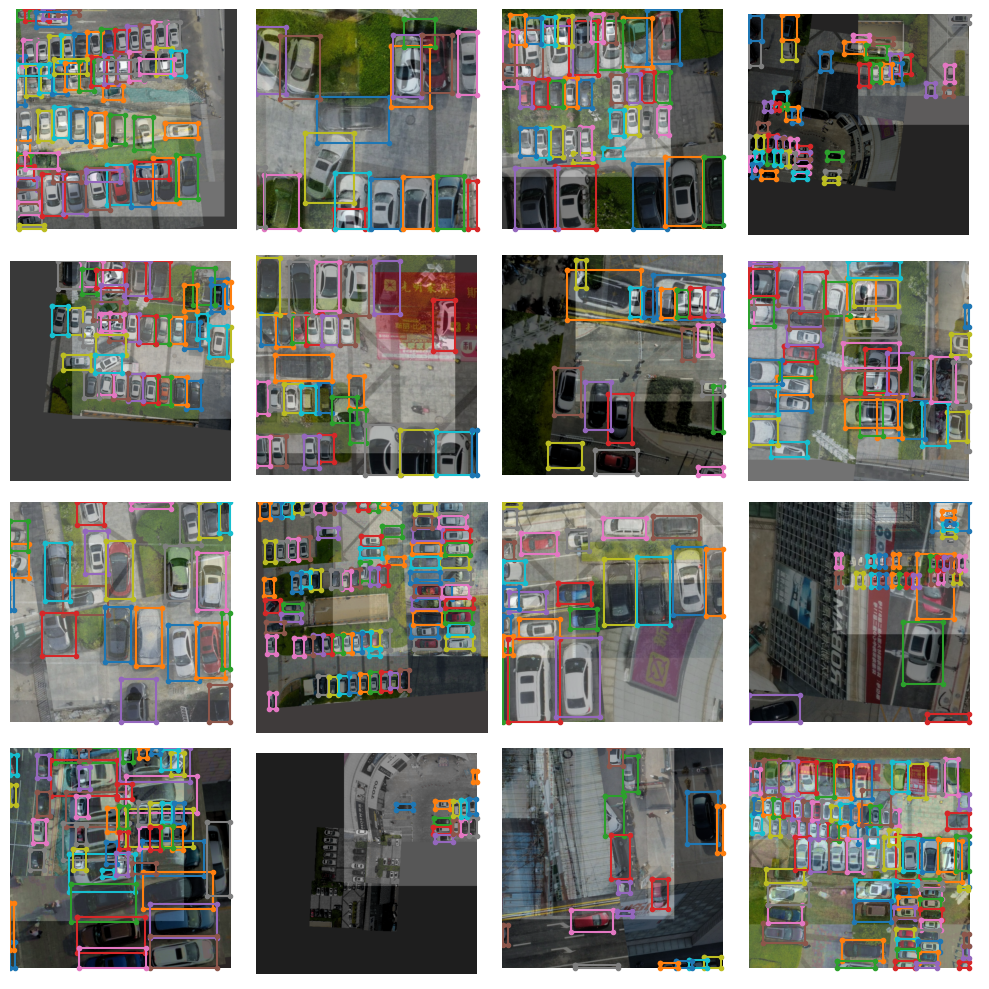

In [7]:
train_data.dataset.plot()

# 👩🏽‍🦳 Instantiate the model

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial you're using `yolo_nas_l`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_s` and `yolo_nas_m`.

In [8]:
model = models.get(config.MODEL_NAME, 
                   num_classes=config.NUM_CLASSES, 
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

# 📊 Define metrics and training parameters

You need to define the training parameters for your training run. 

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`. 

In [9]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# 🦾 Train the model

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model 

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as..

In [10]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

The console stream is now moved to checkpoints/cars-from-above/console_Aug07_23_40_48.txt


[2023-08-07 23:40:49] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
/home/tanmay/.local/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


AssertionError: mixed precision is not available for CPU

# 🏆 Get the best trained model

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs. 

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_best.pth)`

- last weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_latest.pth)`

In [ ]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

# 🧐 Evaluating the best trained model on the test set

In [ ]:
trainer.test(model=best_model,
            test_loader=test_loader,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=config.NUM_CLASSES, 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              nms_threshold=0.7)
                                                  ))

# 🔮 Predicting with the best model

You can make a prediction by calling the `.predict()` method of the model object.

Note, you can set the confidence threshold value as you please.


In [ ]:
best_model.predict( "path/to/your/asset",  conf=0.25).show()

# Post training quantization (PTQ) and quantization aware training (QAT)

SuperGradients offers PTQ and QAT out of the box. That's beyond the scope of this introductory tutorial. It is, in my opinion, a truly awesome feature. 

Not many training libaries offer this out of the box.  You can learn more about PTQ and QAT [here](https://github.com/Deci-AI/super-gradients/blob/c339e2619616878172c060e6491c8c2129ed3fd4/documentation/source/ptq_qat.md).

An example specific to YOLONAS can be found [here](https://github.com/Deci-AI/super-gradients/blob/feature/SG-736_deci_yolo_rf100/documentation/source/qat_ptq_yolo_nas.md).